# Rough

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
import pandas as pd

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
    get_text_annotation
)

from poly2.utils import get_dispersal_kernel, trait_vec
from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture
from poly2.simulator import SimulatorOneTrait

In [8]:
c = Config(asymptote=1)

CONFIG
------
I0s = [0.00985703, 0.00985703, 0.00985703, 0.00985 ...
asymptote = 1
betas = [0.00786542, 0.00786542, 0.00786542, 0.007 ...
decay_rate = None
doses = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1 ...
fungicide_mixture = False
host_on = None
k_b = 0.8431572316700577
k_mu = 9.44286788381916
l_b = 6.585357214619326
l_mu = 0.8089358816813786
mutation_proportion = 1.234375e-05
mutation_scale_fung = 0.0019836158401698102
mutation_scale_host = 0.0019836158401698102
n_k = 50
n_l = 50
n_years = 15
replace_cultivars = None
sprays = None
type = single



In [9]:
s = SimulatorOneTrait(c)

In [10]:
data2 = s.run_model()

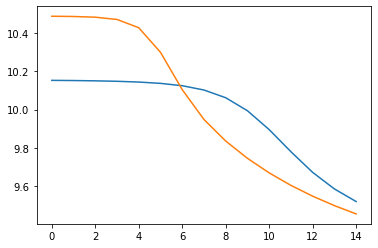

In [11]:
f, ax = plt.subplots()

ax.plot(data['yield_vec'])
ax.plot(data2['yield_vec'])